# Determination des période de maintenance


# sommaire:


- **1. Importation des librairies**

- **2. Datasets Commandes et clients** 

- **3. Application modèle Kmeans**

- **4. Périodes de maintenance**

***

# 1 - Importation des librairies

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

- ## Importation des datasets

In [42]:
# Importation des données
customers_df = pd.read_csv('olist_customers_dataset.csv', usecols=['customer_id', 
                                                                        'customer_unique_id', 
                                                                        'customer_state'])
orders_df = pd.read_csv('olist_orders_dataset.csv', usecols=['order_id', 
                                                                  'customer_id', 
                                                                  'order_status',
                                                                  'order_purchase_timestamp', 
                                                                  'order_approved_at',
                                                                  'order_delivered_customer_date', 
                                                                  'order_estimated_delivery_date'])
order_items_df = pd.read_csv('olist_order_items_dataset.csv', usecols=['order_id', 
                                                                            'price', 
                                                                            'product_id', 
                                                                            'order_item_id'])
order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv', usecols=['order_id', 
                                                                                'review_score'])
order_payments_df = pd.read_csv('olist_order_payments_dataset.csv', usecols=['order_id', 
                                                                            'payment_type', 
                                                                            'payment_value'])


- ## Dataset Combiné

In [43]:
# Jointure des données
merge1 = [orders_df, order_items_df, order_reviews_df]
merge2 = reduce(lambda left, right: pd.merge(left, right, on='order_id', how='outer'), merge1)
merge2 = pd.merge(merge2, customers_df, on='customer_id', how='outer')

# Filtre des commandes annulées
merge2 = merge2[(merge2.order_status != 'canceled') & (merge2.order_status != 'unavailable')]

# Mise au format Datetime des colonnes de dates
date_variables = ['order_approved_at', 
                'order_delivered_customer_date', 
                'order_estimated_delivery_date']

for i in date_variables:
    merge2[i] = pd.to_datetime(merge2[i], errors='coerce').dt.normalize()

# Création d'une colonne temps de livraison
merge2['temps_de_livraison'] = (
    merge2['order_delivered_customer_date'] - merge2['order_approved_at']).dt.days

# Pour certaines valeurs, le temps de livraison est négatif
merge2['temps_de_livraison'] = np.where(
    merge2['temps_de_livraison'] < 0, 0, merge2['temps_de_livraison'])

- ## Dataset Commandes et clients

In [44]:

df_Customers_order = merge2[['temps_de_livraison',
                              'customer_unique_id',
                              'price',
                              'product_id',
                              'review_score',
                              'order_id',
                              'order_approved_at',
                              'customer_state'
                              ]]\
    .groupby(['customer_unique_id', 'order_id'])\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'price': 'mean',
          'order_approved_at': 'max',
          'customer_state': 'max',
          'product_id': 'count'})

df_Customers_order['depenses'] = merge2[['customer_unique_id', 'order_id', 'price']].groupby(
    ['customer_unique_id', 'order_id']).agg('sum')
df_Customers_order = df_Customers_order.reset_index()


- ## Dataset clients

In [24]:
# Création du jeu de données par clients
df_Customers = df_Customers_order.groupby('customer_unique_id')\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'depenses': 'sum'}).round(2)

df_Customers.columns = ['temps_de_livraison_moyen',
                        'review_score_moyen',
                        'first_order',
                        'depenses_totales']

# Date de la dernière commande
df_Customers['last_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Récence (date du jour - date du dernier achat)
df_Customers['recency'] = (
    df_Customers["last_order"].max() - df_Customers['last_order']).dt.days

# nombre de commande totale
df_Customers['nb_order'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# nombre moyen d'article par panier
df_Customers['mean_nb_item'] = df_Customers_order.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

In [25]:
df_Customers.head() 

,temps_de_livraison_moyen,review_score_moyen,first_order,depenses_totales,last_order,recency,nb_order,mean_nb_item
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,5.0,2018-05-10,129.90,2018-05-10,116.0,1,1.0
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,4.0,2018-05-07,18.90,2018-05-07,119.0,1,1.0
0000f46a3911fa3c0805444483337064,26.0,3.0,2017-03-10,69.00,2017-03-10,542.0,1,1.0
0000f6ccb0745a6a4b88665a16c9f078,20.0,4.0,2017-10-12,25.99,2017-10-12,326.0,1,1.0
0004aac84e0df4da2b147fca70cf8255,13.0,5.0,2017-11-14,180.00,2017-11-14,293.0,1,1.0


# 3 - Pipeline de modélisation

In [26]:

features = ['review_score_moyen',
            'nb_order',
            'mean_nb_item']


log_features = ['temps_de_livraison_moyen',
                'depenses_totales',
                'recency']

features_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

logfeatures_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("logTransformation", FunctionTransformer(
               lambda value: np.log1p(value))),
           ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("features", features_transformer, features),
        ("log_features", logfeatures_transformer, log_features),
    ]
)

model_pipeline = Pipeline(steps=[('pre_processing', preprocessor),
                                 ('kmeans', KMeans(random_state=0, n_clusters=6))
                                 ])



# 4 - Création du dataframe  de depart (ensemble des données clients)

In [35]:
# récupération des indes des clients présents du début à la fin de la periode d'analyse
index_clients_debut_fin = df_Customers[df_Customers['first_order'] < df_Customers['last_order'].max() - pd.DateOffset(weeks=26)].index

# Création du df pour le calcul de l'ARI
df_ARI = df_Customers_order.loc[df_Customers_order['customer_unique_id'].isin(index_clients_debut_fin)].copy()


In [37]:
df_ARI.head()

,customer_unique_id,order_id,temps_de_livraison,review_score,price,order_approved_at,customer_state,product_id,depenses
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,26.0,3.0,69.00,2017-03-10,SC,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,20.0,4.0,25.99,2017-10-12,PA,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,13.0,5.0,180.00,2017-11-14,SP,1,180.00
7,00053a61a98854899e70ed204dd4bafe,44e608f2db00c74a1fe329de44416a4e,16.0,1.0,191.00,2018-02-28,PR,2,382.00
8,0005e1862207bf6ccc02e4228effd9a0,ae76bef74b97bcb0b3e355e60d9a6f9c,5.0,4.0,135.00,2017-03-04,RJ,1,135.00


In [38]:
index_clients_debut_fin

Index(['0000f46a3911fa3c0805444483337064', '0000f6ccb0745a6a4b88665a16c9f078',
       '0004aac84e0df4da2b147fca70cf8255', '00053a61a98854899e70ed204dd4bafe',
       '0005e1862207bf6ccc02e4228effd9a0', '0006fdc98a402fceb4eb0ee528f6a8d4',
       '00082cbe03e478190aadbea78542e933', '000a5ad9c4601d2bbdd9ed765d5213b3',
       '000bfa1d2f1a41876493be685390d6d3', '000c8bdb58a29e7115cfc257230fb21b',
       ...
       'fff3a9369e4b7102fab406a334a678c3', 'fff699c184bcc967d62fa2c6171765f7',
       'fff7219c86179ca6441b8f37823ba3d3', 'fffa431dd3fcdefea4b1777d114144f2',
       'fffb09418989a0dbff854a28163e47c6', 'fffbf87b7a1a6fa8b03f081c5f51a201',
       'fffcf5a5ff07b0908bd4e2dbc735a684', 'fffea47cd6d3cc0a88bd621562a9d061',
       'ffff371b4d645b6ecea244b27531430a', 'ffffd2657e2aad2907e67c3e9daecbeb'],
      dtype='object', name='customer_unique_id', length=57446)

In [39]:
# Dataset 26 semaine avant la fin de periode generale
date_debut_experience = (df_Customers['last_order'].max() - pd.DateOffset(weeks=26)).strftime("%Y-%m-%d")
Dataset_commandes_26_avant = df_ARI[df_ARI['order_approved_at'] < date_debut_experience]


Dataset_clients_26_avant = Dataset_commandes_26_avant.groupby('customer_unique_id')\
    .agg({'temps_de_livraison': 'mean',
          'review_score': 'mean',
          'order_approved_at': 'min',
          'depenses': 'sum'}).round(2)

Dataset_clients_26_avant.columns = ['temps_de_livraison_moyen',
                            'review_score_moyen',
                            'first_order',
                            'depenses_totales']

# Date de la dernière commande
Dataset_clients_26_avant['last_order'] = Dataset_commandes_26_avant.groupby(
    'customer_unique_id').agg({'order_approved_at': 'max'})

# Recency : (date du jour - date du dernier achat)
Dataset_clients_26_avant['recency'] = (
    Dataset_clients_26_avant["last_order"].max() - Dataset_clients_26_avant['last_order']).dt.days

# Nb_order : nombre de commande totale
Dataset_clients_26_avant['nb_order'] = Dataset_commandes_26_avant.groupby(
    'customer_unique_id').agg({'order_id': 'count'})

# Mean_nb_item : nombre moyen d'article par panier
Dataset_clients_26_avant['mean_nb_item'] = Dataset_commandes_26_avant.groupby(
    'customer_unique_id').agg({'product_id': 'mean'}).round(2)

#df_t0 = Dataset_clients_26_avant

In [40]:
date_debut_experience

'2018-03-05'

In [29]:
# Exécution du modèle KMEANS sur le DataFrame df_depart à l'aide de model_pipeline.fit_predict(). 
# Le résultat du modèle est ensuite stocké dans un nouveau DataFrame appelé clusters_weeks.
entrainement = pd.DataFrame(model_pipeline.fit_predict(Dataset_clients_26_avant), columns=[date_debut_experience])
predictions = pd.DataFrame(model_pipeline.predict(Dataset_clients_26_avant), columns=[date_debut_experience])


In [32]:
for week in range(25, -1, -1):
    # Date de début d'expérience:
    date_debut_experience = (df_Customers['last_order'].max(
    ) - pd.DateOffset(weeks=week)).strftime("%Y-%m-%d")

    # création du dataframe contenant toutes les ventes de la première vente à la dernièrevente - semaine :
    Dataset_commandes_26_avant = df_ARI[df_ARI['order_approved_at'] < date_debut_experience]

    
    # création du dataframe regroupé par client
    Dataset_clients_26_avant = Dataset_commandes_26_avant.groupby('customer_unique_id')\
        .agg({'temps_de_livraison': 'mean',
              'review_score': 'mean',
              'order_approved_at': 'min',
              'depenses': 'sum'}).round(2)

    Dataset_clients_26_avant.columns = ['temps_de_livraison_moyen',
                                'review_score_moyen',
                                'first_order',
                                'depenses_totales']

    
    # Date de la dernière commande
    Dataset_clients_26_avant['last_order'] = Dataset_commandes_26_avant.groupby(
        'customer_unique_id').agg({'order_approved_at': 'max'})

    # Recency : (date du jour - date du dernier achat)
    Dataset_clients_26_avant['recency'] = (
        Dataset_clients_26_avant["last_order"].max() - Dataset_clients_26_avant['last_order']).dt.days

    # Nb_order : nombre de commande totale
    Dataset_clients_26_avant['nb_order'] = Dataset_commandes_26_avant.groupby(
        'customer_unique_id').agg({'order_id': 'count'})

    # Mean_nb_item : nombre moyen d'article par panier
    Dataset_clients_26_avant['mean_nb_item'] = Dataset_commandes_26_avant.groupby(
        'customer_unique_id').agg({'product_id': 'mean'}).round(2)

    # Entrainement du modèle sur le df au temps n et Prédiction des clusters : stablitié des cluster
    entrainement[date_debut_experience] = model_pipeline.fit_predict(Dataset_clients_26_avant)

    # Prédiction des clusters: contrat de maintenance
    model_pipeline.fit(Dataset_clients_26_avant)
    predictions[date_debut_experience] = model_pipeline.predict(Dataset_clients_26_avant)
    

In [33]:
# Ce code calcule l'indice de similarité entre les clusters générés par l'algorithme 
# KMeans sur des données de ventes en ligne sur une période de 24 semaines

# Cette liste stocke les résultats de similarité entre les clusters pour 
# chaque paire de semaines adjacentes
ARI_kmeans = []

# liste stocke les résultats de similarité entre les clusters de la 
# première semaine et les clusters de chaque semaine ultérieure
ARI_kmeans2 = []

for col in range(0, 26):
    temp = adjusted_rand_score(
        entrainement.iloc[:, col], entrainement.iloc[:, col+1])
    ARI_kmeans.append(temp)

    temp = adjusted_rand_score(
        predictions.iloc[:, 0], predictions.iloc[:, col])
    ARI_kmeans2.append(temp)


stability = pd.DataFrame(ARI_kmeans, columns=["ARI"])
stability['Date'] = list(entrainement.columns)[:-1]


maintenance = pd.DataFrame(ARI_kmeans2, columns=["ARI"])
maintenance['Date'] = list(predictions.columns)[:-1]



In [34]:
# Créer un dataframe pour ARI_kmeans_stability
maintenance_df = pd.DataFrame({'Date': predictions.columns[:-1], 'Score ARI': ARI_kmeans2})
# Trier le dataframe par date
ARI_df = maintenance_df.sort_values(by='Date')
# Réinitialiser l'index
ARI_df = ARI_df.reset_index(drop=True)
ARI_df = pd.DataFrame(ARI_df)
ARI_df 


,Date,Score ARI
0,2018-03-05,1.000000
1,2018-03-12,0.853862
2,2018-03-19,0.801961
3,2018-03-26,0.769188
4,2018-04-02,0.742927
5,2018-04-09,0.726867
6,2018-04-16,0.698368
7,2018-04-23,0.700930
8,2018-04-30,0.685406
9,2018-05-07,0.662014


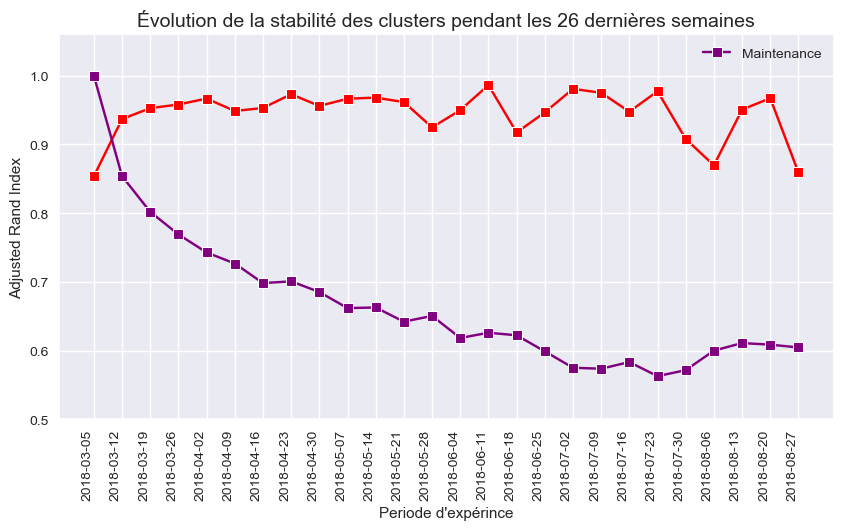

In [16]:
plt.figure(figsize=(10, 5), dpi=100)
sns.set_style('darkgrid')
sns.lineplot(data=stability, x='Date', y='ARI',
             marker="s", color='red')
sns.lineplot(data=maintenance, x='Date', y='ARI',
             marker="s", color='purple', label='Maintenance')
plt.xlabel("Periode d'expérince")
plt.xticks(rotation=90, ha='right')
plt.ylabel("Adjusted Rand Index")
plt.title("Évolution de la stabilité des clusters pendant les 26 dernières semaines", fontsize=14)
plt.ylim(0.5, 1.06)
plt.show()

### **Remarques**
- La courbe de stabilité est horizontale jusqu'au 21 mai 2018, indiquant que la partition des clusters est relativement stable et cohérente dans le temps.
- Une baisse de la cohérence de la partition des clusters est constatée à partir du 3è mois, necessitant une mise à jour. 